# Setup

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import holidays

import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pytorch_lightning as pl
from src.prepare_data import TSDataset, generate_lags
from src.feature_engineering import (add_holiday, add_day_length, add_temporal, 
                                     add_weekends, add_sun_position, generate_cyclic_features)
from src.model_training import TrainingLoop, Pipeline
from src.models import GatedRecurrentUnit
from src.inference import format_predictions, calculate_metrics

In [4]:
load_data = pd.read_csv('../data/electricity_load_data.csv', parse_dates=True, index_col=['datetime'])
load_data.head()

,load
datetime,
2019-01-01 00:00:00,112.01
2019-01-01 01:00:00,92.44
2019-01-01 02:00:00,84.52
2019-01-01 03:00:00,75.36
2019-01-01 04:00:00,63.64


In [5]:
# Generate target and input variables
dataset = TSDataset(dataframe=load_data, target_variable='load')
X, y = dataset.to_supervised(n_lags=0, horizon=1)

In [6]:
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
X.head()

,load
datetime,
2019-01-01 00:00:00,112.01
2019-01-01 01:00:00,92.44
2019-01-01 02:00:00,84.52
2019-01-01 03:00:00,75.36
2019-01-01 04:00:00,63.64


In [8]:
y.head()

,load+1
datetime,
2019-01-01 00:00:00,92.44
2019-01-01 01:00:00,84.52
2019-01-01 02:00:00,75.36
2019-01-01 03:00:00,63.64
2019-01-01 04:00:00,56.20


# Independent Variables & Feature Engineering
**What data can we use to improve the forecast?**

There are many different independent variables and features we could use for a forecast:
- Holiday indicator
- Weekend indicator
- Hour of day
- Day of week
- Week of year
- Month of year
- Quarter of year
- Day length
- Position and Angle of the Sun
- Weather
- ... and many more

## Holidays
Requires to be installed with `pip`:   
`!pip install holidays` - can be done within a Jupyter Notebook

In [9]:
# Assign danish holidays
holidays_dk = holidays.DK()

In [10]:
features = add_holiday(X, holidays_dk)

In [11]:
features.head()

,load,is_holiday
datetime,,
2019-01-01 00:00:00,112.01,1
2019-01-01 01:00:00,92.44,1
2019-01-01 02:00:00,84.52,1
2019-01-01 03:00:00,75.36,1
2019-01-01 04:00:00,63.64,1


<Axes: xlabel='datetime'>

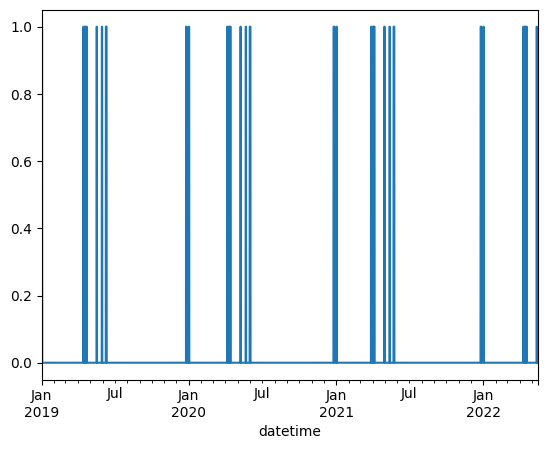

In [12]:
features['is_holiday'].plot()

## Temporal Feature Engineering
### Hour, Day, Month, Week, Quarter

In [13]:
temporal_features = ['hour', 'day_of_week', 'week', 'month', 'quarter']
features = add_temporal(features, temporal_features)

In [14]:
features.head()

,load,is_holiday,hour,day_of_week,week,month,quarter
datetime,,,,,,,
2019-01-01 00:00:00,112.01,1,0,1,1,1,1
2019-01-01 01:00:00,92.44,1,1,1,1,1,1
2019-01-01 02:00:00,84.52,1,2,1,1,1,1
2019-01-01 03:00:00,75.36,1,3,1,1,1,1
2019-01-01 04:00:00,63.64,1,4,1,1,1,1


### Encode Temporal Features using Sine and Cosine Transformations

In [15]:
# Check description to see what the starting number of temporal features is
features.describe()

,load,is_holiday,hour,day_of_week,week,month,quarter
count,29543.000000,29543.000000,29543.000000,29543.000000,29543.0,29543.000000,29543.000000
mean,83.722999,0.034932,11.499611,3.002336,24.888908,6.111329,2.379379
std,31.030956,0.183611,6.922098,1.998974,15.275955,3.485926,1.127147
min,37.010000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000
25%,58.716447,0.000000,5.500000,1.000000,12.0,3.000000,1.000000
50%,80.290000,0.000000,11.000000,3.000000,24.0,6.000000,2.000000
75%,101.365000,0.000000,17.000000,5.000000,38.0,9.000000,3.000000
max,253.900000,1.000000,23.000000,6.000000,53.0,12.000000,4.000000


In [16]:
features = generate_cyclic_features(
    dataframe=features, col_names=temporal_features, periods=[24, 7, 53, 12, 4], start_nums=[0, 0, 1, 1, 1])

In [17]:
features.head()

,load,is_holiday,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,sin_week,cos_week,sin_month,cos_month,sin_quarter,cos_quarter
datetime,,,,,,,,,,,,
2019-01-01 00:00:00,112.01,1,0.000000,1.000000,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0
2019-01-01 01:00:00,92.44,1,0.258819,0.965926,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0
2019-01-01 02:00:00,84.52,1,0.500000,0.866025,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0
2019-01-01 03:00:00,75.36,1,0.707107,0.707107,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0
2019-01-01 04:00:00,63.64,1,0.866025,0.500000,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0


#### Example: Hourly feature transformed to sine and cosine waves

<Axes: xlabel='datetime'>

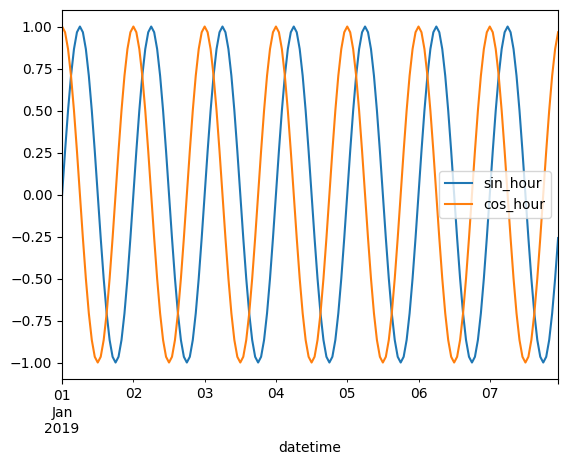

In [18]:
features.iloc[:168][['sin_hour', 'cos_hour']].plot()

#### Example: Week number feature transformed to sine and cosine waves

<Axes: xlabel='datetime'>

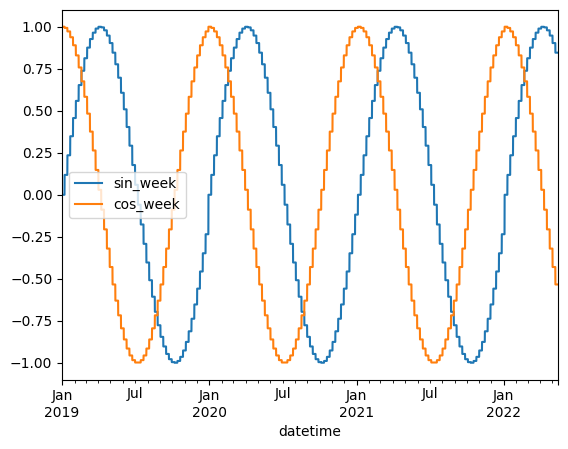

In [19]:
features[['sin_week', 'cos_week']].plot()

<Axes: xlabel='datetime'>

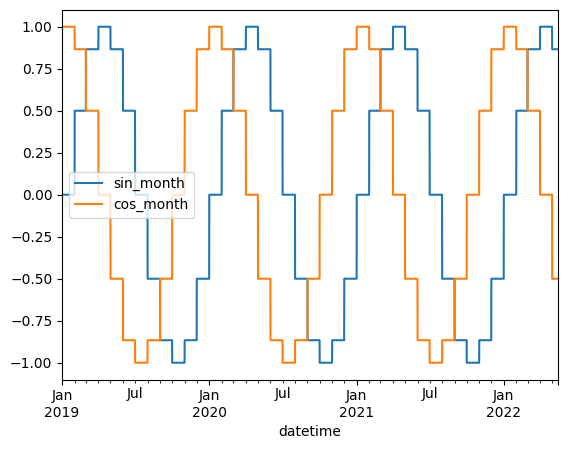

In [20]:
features[['sin_month', 'cos_month']].plot()

## Weekends

In [21]:
features = add_weekends(features)

In [22]:
features.head()

,load,is_holiday,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,sin_week,cos_week,sin_month,cos_month,sin_quarter,cos_quarter,weekend
datetime,,,,,,,,,,,,,
2019-01-01 00:00:00,112.01,1,0.000000,1.000000,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0
2019-01-01 01:00:00,92.44,1,0.258819,0.965926,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0
2019-01-01 02:00:00,84.52,1,0.500000,0.866025,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0
2019-01-01 03:00:00,75.36,1,0.707107,0.707107,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0
2019-01-01 04:00:00,63.64,1,0.866025,0.500000,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0


## Solar Height and Angle
Requires the `suncalc` library:  
`!pip install suncalc`

In [23]:
lat = 55.73
lon = 9.58

In [24]:
features = add_sun_position(features, lon, lat)
features.head()

,load,is_holiday,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,sin_week,cos_week,sin_month,cos_month,sin_quarter,cos_quarter,weekend,sun_azimuth,sun_altitude
datetime,,,,,,,,,,,,,,,
2019-01-01 00:00:00,112.01,1,0.000000,1.000000,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0,-2.886408,-0.989872
2019-01-01 01:00:00,92.44,1,0.258819,0.965926,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0,-2.481799,-0.924471
2019-01-01 02:00:00,84.52,1,0.500000,0.866025,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0,-2.146838,-0.815877
2019-01-01 03:00:00,75.36,1,0.707107,0.707107,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0,-1.871996,-0.682573
2019-01-01 04:00:00,63.64,1,0.866025,0.500000,0.781831,0.62349,0.0,1.0,0.0,1.0,0.0,1.0,0,-1.636568,-0.537901


array([<Axes: xlabel='datetime'>], dtype=object)

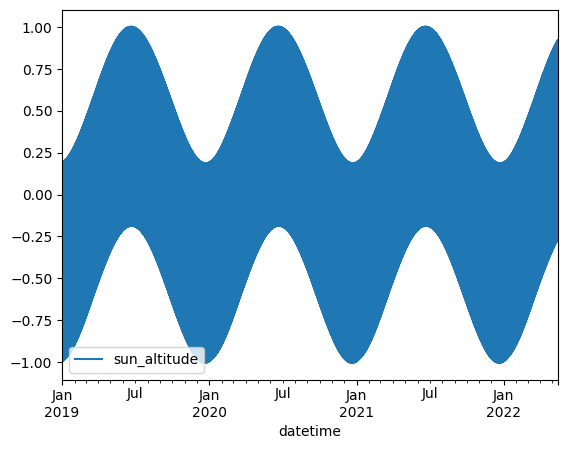

In [25]:
features[['sun_altitude']].plot(subplots=True)

array([<Axes: xlabel='datetime'>], dtype=object)

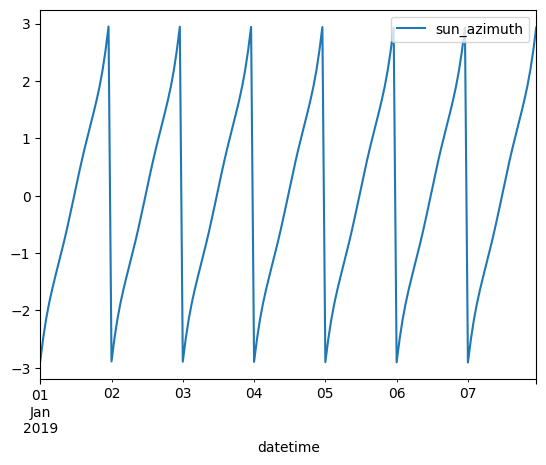

In [26]:
features.iloc[:168][['sun_azimuth']].plot(subplots=True)

## Day lengths

In [27]:
features = add_day_length(features, lon, lat)

<Axes: xlabel='datetime'>

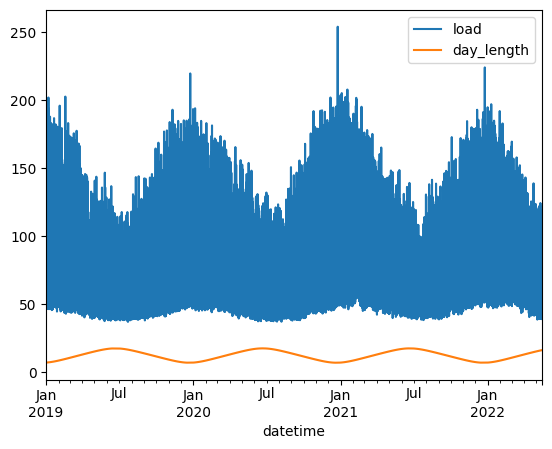

In [30]:
features[['load', 'day_length']].plot()

# Feature Selection

*Correlation: Select features correlated with the target variable, but not with other independent variables*

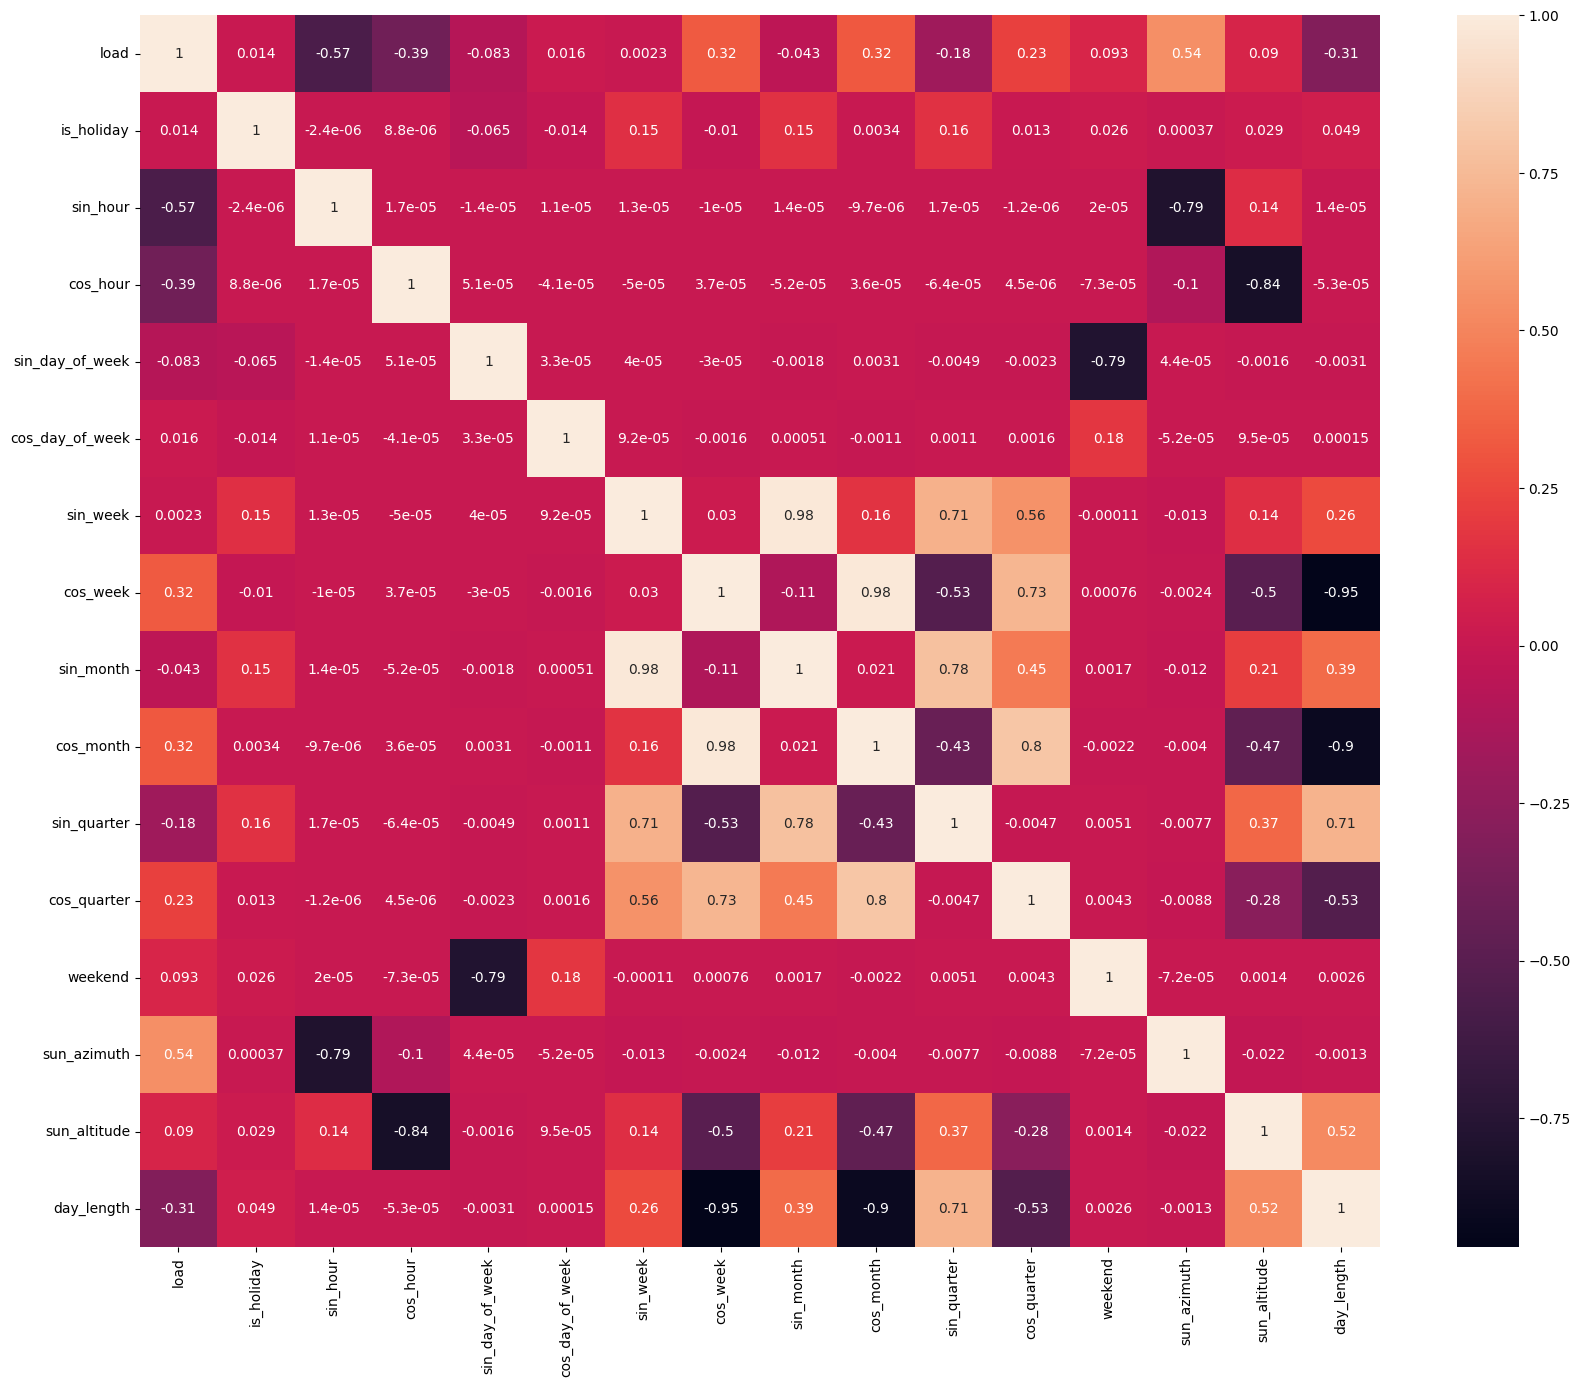

In [31]:
plt.figure(figsize=(20,16))
sns.heatmap(features.corr('pearson'), annot=True)
plt.show()

## Rule of Thumb for Feature Selection based on Correllation
- Select features that correllate with the target variable, but not with other independent variables.

## ...however, there are some tools
### Feature Selection with scikit-learn

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression

In [33]:
feature_selection = SelectKBest(score_func=f_regression, k=6)
features_new = feature_selection.fit_transform(features, y.values[:, 0])

In [34]:
for s, f in zip(feature_selection.scores_.tolist(), feature_selection.feature_names_in_.tolist()):
    print("Feature:", f, "- Score:", round(s, 2))

Feature: load - Score: 130417.52
Feature: is_holiday - Score: 4.77
Feature: sin_hour - Score: 7552.12
Feature: cos_hour - Score: 11457.58
Feature: sin_day_of_week - Score: 202.32
Feature: cos_day_of_week - Score: 5.79
Feature: sin_week - Score: 0.14
Feature: cos_week - Score: 3476.56
Feature: sin_month - Score: 54.28
Feature: cos_month - Score: 3272.03
Feature: sin_quarter - Score: 946.64
Feature: cos_quarter - Score: 1614.04
Feature: weekend - Score: 245.62
Feature: sun_azimuth - Score: 5720.09
Feature: sun_altitude - Score: 1495.62
Feature: day_length - Score: 3201.47


In [35]:
top_features = pd.DataFrame(features_new, columns=feature_selection.get_feature_names_out(), index=features.index)
top_features.head()

,load,sin_hour,cos_hour,cos_week,cos_month,sun_azimuth
datetime,,,,,,
2019-01-01 00:00:00,112.01,0.000000,1.000000,1.0,1.0,-2.886408
2019-01-01 01:00:00,92.44,0.258819,0.965926,1.0,1.0,-2.481799
2019-01-01 02:00:00,84.52,0.500000,0.866025,1.0,1.0,-2.146838
2019-01-01 03:00:00,75.36,0.707107,0.707107,1.0,1.0,-1.871996
2019-01-01 04:00:00,63.64,0.866025,0.500000,1.0,1.0,-1.636568


#### Lags

In [36]:
features_lags = generate_lags(features[['load']], 23, 'load')

In [37]:
features_lags.head()

,load,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,load-9,...,load-14,load-15,load-16,load-17,load-18,load-19,load-20,load-21,load-22,load-23
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 23:00:00,73.96,91.42,114.38,135.19,154.26,176.40,185.08,146.50,124.94,133.26,...,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52,92.44,112.01
2019-01-02 00:00:00,61.68,73.96,91.42,114.38,135.19,154.26,176.40,185.08,146.50,124.94,...,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52,92.44
2019-01-02 01:00:00,54.35,61.68,73.96,91.42,114.38,135.19,154.26,176.40,185.08,146.50,...,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52
2019-01-02 02:00:00,51.65,54.35,61.68,73.96,91.42,114.38,135.19,154.26,176.40,185.08,...,127.97,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36
2019-01-02 03:00:00,49.20,51.65,54.35,61.68,73.96,91.42,114.38,135.19,154.26,176.40,...,122.67,127.97,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64


In [38]:
feature_selection = SelectKBest(score_func=f_regression, k=6)
features_new = feature_selection.fit_transform(features_lags, y.values[23:, 0])

In [39]:
for s, f in zip(feature_selection.scores_.tolist(), feature_selection.feature_names_in_.tolist()):
    print("Feature:", f, "- Score:", round(s, 2))

Feature: load - Score: 130268.54
Feature: load-1 - Score: 29347.04
Feature: load-2 - Score: 9061.35
Feature: load-3 - Score: 2265.94
Feature: load-4 - Score: 148.91
Feature: load-5 - Score: 214.48
Feature: load-6 - Score: 1054.19
Feature: load-7 - Score: 1628.54
Feature: load-8 - Score: 1668.01
Feature: load-9 - Score: 1502.76
Feature: load-10 - Score: 1433.68
Feature: load-11 - Score: 1452.54
Feature: load-12 - Score: 1460.88
Feature: load-13 - Score: 1553.49
Feature: load-14 - Score: 1729.5
Feature: load-15 - Score: 1683.35
Feature: load-16 - Score: 1102.33
Feature: load-17 - Score: 248.52
Feature: load-18 - Score: 106.21
Feature: load-19 - Score: 1965.92
Feature: load-20 - Score: 7876.07
Feature: load-21 - Score: 23948.48
Feature: load-22 - Score: 78065.23
Feature: load-23 - Score: 200245.46


In [40]:
top_lags = pd.DataFrame(features_lags, columns=feature_selection.get_feature_names_out(), index=features_lags.index)
top_lags.head()

,load,load-1,load-2,load-21,load-22,load-23
datetime,,,,,,
2019-01-01 23:00:00,73.96,91.42,114.38,84.52,92.44,112.01
2019-01-02 00:00:00,61.68,73.96,91.42,75.36,84.52,92.44
2019-01-02 01:00:00,54.35,61.68,73.96,63.64,75.36,84.52
2019-01-02 02:00:00,51.65,54.35,61.68,56.20,63.64,75.36
2019-01-02 03:00:00,49.20,51.65,54.35,57.83,56.20,63.64


### Comparing with a model
#### No additional data

In [36]:
# Hyperparameters
output_size = 1
hidden_size = 64
num_layers = 1
dropout_prob = 0
learning_rate = 1e-2
batch_size = 64

optimizer = 'SGD'
loss_fn = nn.MSELoss()

In [37]:
pipe_nofeatures = Pipeline(inputs=X, targets=y, use_validation=True, test_ratio=0.2)
x_scaler, y_scaler = RobustScaler(), RobustScaler()
train, val, test, y_scaler = pipe_nofeatures.run(x_scaler, y_scaler)
input_size = len(X.columns) 

In [39]:
# Build model
model = GatedRecurrentUnit(
    hidden_size = hidden_size,
    num_rnn_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    dropout = dropout_prob,
    device = 'cpu'
    )


print(model)

GatedRecurrentUnit(
  (gru): GRU(1, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [40]:
train_loop = TrainingLoop(
            model=model, 
            datasets=(train, val, test),
            learning_rate=learning_rate,
            batch_size=batch_size,
            optimizer=optimizer,
            accelerator='cpu',
            train_shuffle=False
        )

In [41]:
trainer = pl.Trainer(
    accelerator='cpu',
    devices=1,
    min_epochs=1,
    max_epochs=20,
    gradient_clip_val=0,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [42]:
trainer.fit(train_loop)

Missing logger folder: C:\Users\nicol\Documents\Teaching\ml_kursus\notebooks\lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | GatedRecurrentUnit | 12.9 K
---------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.052     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [47]:
trainer.test(ckpt_path='best')

In [48]:
predictions, labels = train_loop.predictions, train_loop.values

In [49]:
df_result_nofeatures = format_predictions(predictions, labels, X_test, y_scaler)

In [50]:
nofs_metrics = calculate_metrics(df_result_nofeatures)

#### Non-lag Features

In [46]:
pipe_nonlag = Pipeline(inputs=top_features, targets=y, use_validation=True, test_ratio=0.2)

In [47]:
x_scaler, y_scaler = RobustScaler(), RobustScaler()

In [48]:
train, val, test, y_scaler = pipe_nonlag.run(x_scaler, y_scaler)

In [49]:
input_size = len(top_features.columns) 

In [50]:
# Build model
model = GatedRecurrentUnit(
    hidden_size = hidden_size,
    num_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    dropout = dropout_prob,
    device = 'cpu'
    )


print(model)

GatedRecurrentUnit(
  (gru): GRU(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [51]:
train_loop = TrainingLoop(
            model=model, 
            datasets=(train, val, test),
            learning_rate=learning_rate,
            batch_size=batch_size,
            optimizer=optimizer,
            accelerator='cpu',
            train_shuffle=False
        )

In [52]:
trainer = pl.Trainer(
    accelerator='cpu',
    devices=1,
    min_epochs=1,
    max_epochs=20,
    gradient_clip_val=0,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [53]:
trainer.fit(train_loop)


  | Name  | Type               | Params
---------------------------------------------
0 | model | GatedRecurrentUnit | 13.9 K
---------------------------------------------
13.9 K    Trainable params
0         Non-trainable params
13.9 K    Total params
0.056     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [54]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at c:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_28\checkpoints\epoch=19-step=5520.ckpt
Loaded model weights from the checkpoint at c:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_28\checkpoints\epoch=19-step=5520.ckpt
c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [55]:
predictions, labels = train_loop.predictions, train_loop.values

In [56]:
df_result_nonlag = format_predictions(predictions, labels, X_test, y_scaler)

In [57]:
nonlag_metrics = calculate_metrics(df_result_nonlag)

Mean Absolute Error: 8.838546
Mean Absolute % Error: 9.876897931098938
Symmetric Mean Absolute % Error: 9.876897931098938
Root Mean Squared Error: 11.906906149898889
R^2 Score: 0.8545461412301545


#### Lags as Features

In [58]:
pipe_lagfeatures = Pipeline(inputs=top_lags, targets=y[23:], use_validation=True, test_ratio=0.2)
x_scaler, y_scaler = RobustScaler(), RobustScaler()
train, val, test, y_scaler = pipe_lagfeatures.run(x_scaler, y_scaler)
input_size = len(top_lags.columns)

In [59]:
# Build model
model = GatedRecurrentUnit(
    hidden_size = hidden_size,
    num_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    dropout = dropout_prob,
    device = 'cpu'
    )


print(model)

GatedRecurrentUnit(
  (gru): GRU(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [60]:
train_loop = TrainingLoop(
            model=model, 
            datasets=(train, val, test),
            learning_rate=learning_rate,
            batch_size=batch_size,
            optimizer=optimizer,
            accelerator='cpu',
            train_shuffle=False
        )

In [61]:
trainer = pl.Trainer(
    accelerator='cpu',
    devices=1,
    min_epochs=1,
    max_epochs=20,
    gradient_clip_val=0,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [62]:
trainer.fit(train_loop)


  | Name  | Type               | Params
---------------------------------------------
0 | model | GatedRecurrentUnit | 13.9 K
---------------------------------------------
13.9 K    Trainable params
0         Non-trainable params
13.9 K    Total params
0.056     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [63]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at c:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_29\checkpoints\epoch=19-step=5520.ckpt
Loaded model weights from the checkpoint at c:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_29\checkpoints\epoch=19-step=5520.ckpt
c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [64]:
predictions, labels = train_loop.predictions, train_loop.values

In [65]:
df_result_lagfeatures = format_predictions(predictions, labels, X_test[23:], y_scaler)

In [66]:
lag_metrics = calculate_metrics(df_result_lagfeatures)

Mean Absolute Error: 5.774572
Mean Absolute % Error: 6.460019201040268
Symmetric Mean Absolute % Error: 6.460019201040268
Root Mean Squared Error: 8.077190883793833
R^2 Score: 0.9331383998040288


#### Combining Features and Lags

In [67]:
combined_features = pd.concat([top_features, top_lags.drop(columns='load')], axis=1).dropna()

In [68]:
combined_features

,load,sin_hour,cos_hour,cos_week,cos_month,sun_azimuth,load-1,load-2,load-21,load-22,load-23
datetime,,,,,,,,,,,
2019-01-01 23:00:00,73.96,-0.258819,9.659258e-01,1.000000,1.0,2.950893,91.42,114.38,84.52,92.44,112.01
2019-01-02 00:00:00,61.68,0.000000,1.000000e+00,1.000000,1.0,-2.890219,73.96,91.42,75.36,84.52,92.44
2019-01-02 01:00:00,54.35,0.258819,9.659258e-01,1.000000,1.0,-2.485595,61.68,73.96,63.64,75.36,84.52
2019-01-02 02:00:00,51.65,0.500000,8.660254e-01,1.000000,1.0,-2.150270,54.35,61.68,56.20,63.64,75.36
2019-01-02 03:00:00,49.20,0.707107,7.071068e-01,1.000000,1.0,-1.875046,51.65,54.35,57.83,56.20,63.64
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-15 18:00:00,109.27,-1.000000,-1.836970e-16,-0.533823,-0.5,1.905136,112.67,108.45,70.46,78.10,88.94
2022-05-15 19:00:00,93.25,-0.965926,2.588190e-01,-0.533823,-0.5,2.115297,109.27,112.67,59.48,70.46,78.10
2022-05-15 20:00:00,80.74,-0.866025,5.000000e-01,-0.533823,-0.5,2.333811,93.25,109.27,51.71,59.48,70.46


In [69]:
pipe_combined = Pipeline(inputs=combined_features, targets=y[23:], use_validation=True, test_ratio=0.2)
x_scaler, y_scaler = RobustScaler(), RobustScaler()
train, val, test, y_scaler = pipe_combined.run(x_scaler, y_scaler)
input_size = len(combined_features.columns)

In [70]:
# Build model
model = GatedRecurrentUnit(
    hidden_size = hidden_size,
    num_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    dropout = dropout_prob,
    device = 'cpu'
    )


print(model)

GatedRecurrentUnit(
  (gru): GRU(11, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [71]:
train_loop = TrainingLoop(
            model=model, 
            datasets=(train, val, test),
            learning_rate=learning_rate,
            batch_size=batch_size,
            optimizer=optimizer,
            accelerator='cpu',
            train_shuffle=False
        )

In [72]:
trainer = pl.Trainer(
    accelerator='cpu',
    devices=1,
    min_epochs=1,
    max_epochs=20,
    gradient_clip_val=0,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [73]:
trainer.fit(train_loop)


  | Name  | Type               | Params
---------------------------------------------
0 | model | GatedRecurrentUnit | 14.8 K
---------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [74]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at c:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_30\checkpoints\epoch=19-step=5520.ckpt
Loaded model weights from the checkpoint at c:\Users\nva\Documents\Teaching\external\lighthouse-course\notebooks\lightning_logs\version_30\checkpoints\epoch=19-step=5520.ckpt
c:\Users\nva\Documents\Teaching\external\lighthouse-course\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [75]:
predictions, labels = train_loop.predictions, train_loop.values

In [76]:
df_result_combined = format_predictions(predictions, labels, X_test[23:], y_scaler)

In [77]:
combined_metrics = calculate_metrics(df_result_combined)

Mean Absolute Error: 5.752746
Mean Absolute % Error: 6.445767730474472
Symmetric Mean Absolute % Error: 6.445767730474472
Root Mean Squared Error: 8.049917412565243
R^2 Score: 0.9335891707611054


### Evaluate Features

In [80]:
metrics = pd.DataFrame([nofs_metrics, nonlag_metrics, lag_metrics, combined_metrics], index=["No Feature Selection", "Top 6 Features", "Top 6 Lags", "Combined Features and Lags"])

In [81]:
metrics

,mae,mape,smape,rmse,r2
No Feature Selection,10.221649,11.640018,11.478539,13.811196,0.804300
Top 6 Features,8.838546,9.876898,9.867902,11.906906,0.854546
Top 6 Lags,5.774572,6.460019,6.380043,8.077191,0.933138
Combined Features and Lags,5.752746,6.445768,6.359414,8.049917,0.933589


# Feature Importance
We can use Decision Trees to calculate feature importance of predicting the target variable.

In [41]:
X = features.drop(['load_t+1'], axis=1)
y = features[['load_t+1']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling due to larger values affecting the decision tree
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scl = x_scaler.fit_transform(X_train)
X_test_scl = x_scaler.transform(X_test)
y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

# Decision Matrix
dmat = xgb.DMatrix(X_train_scl, y_train_scl, feature_names=X.columns.values)

KeyError: "['load_t+1'] not found in axis"

In [78]:
params = {
    'eta': 0.05,
    'max_depth': 10,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

model = xgb.train(dict(params), dmat, num_boost_round=100)

Gain:
- The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction

Coverage:
- The Coverage metric means the relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features’ cover metrics.

Weight:
- The Weight is the percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weight for feature1 will be 2+1+3 = 6. The frequency for feature1 is calculated as its percentage weight over weights of all features.


The Gain is the most relevant attribute to interpret the relative importance of each feature.

## Feature Importance using Decision Matrix

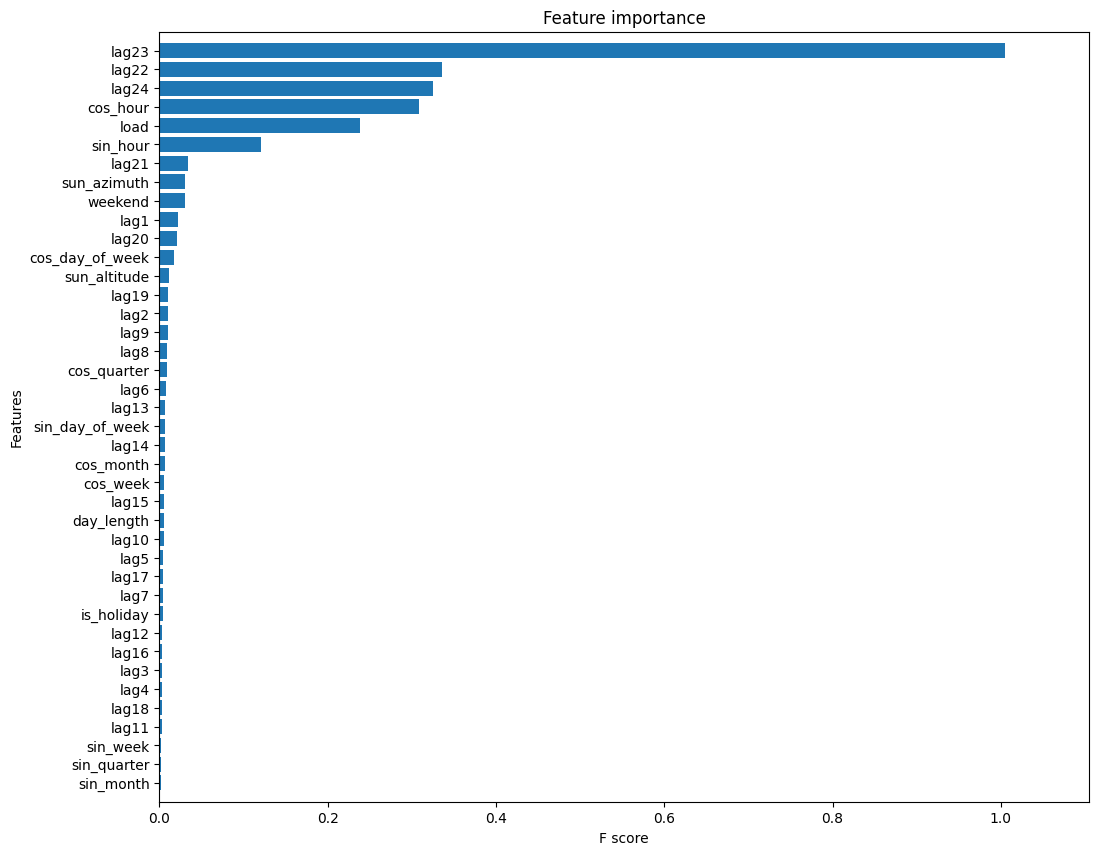

In [79]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(model, height=0.8, ax=ax, importance_type='gain', show_values=False, grid=False)
plt.show()

## Feature Importance using XGBoost Regressor

In [80]:
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=10, kwargs=dict(params), importance_type='gain')
xgb_reg.fit(X_train_scl, y_train_scl)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type='gain',
             interaction_constraints='',
             kwargs={'colsample_bytree': 0.7, 'eta': 0.05,
                     'eval_metric': 'rmse', 'max_depth': 10,
                     'objective': 'reg:squarederror', 'subsample': 1.0},
             learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

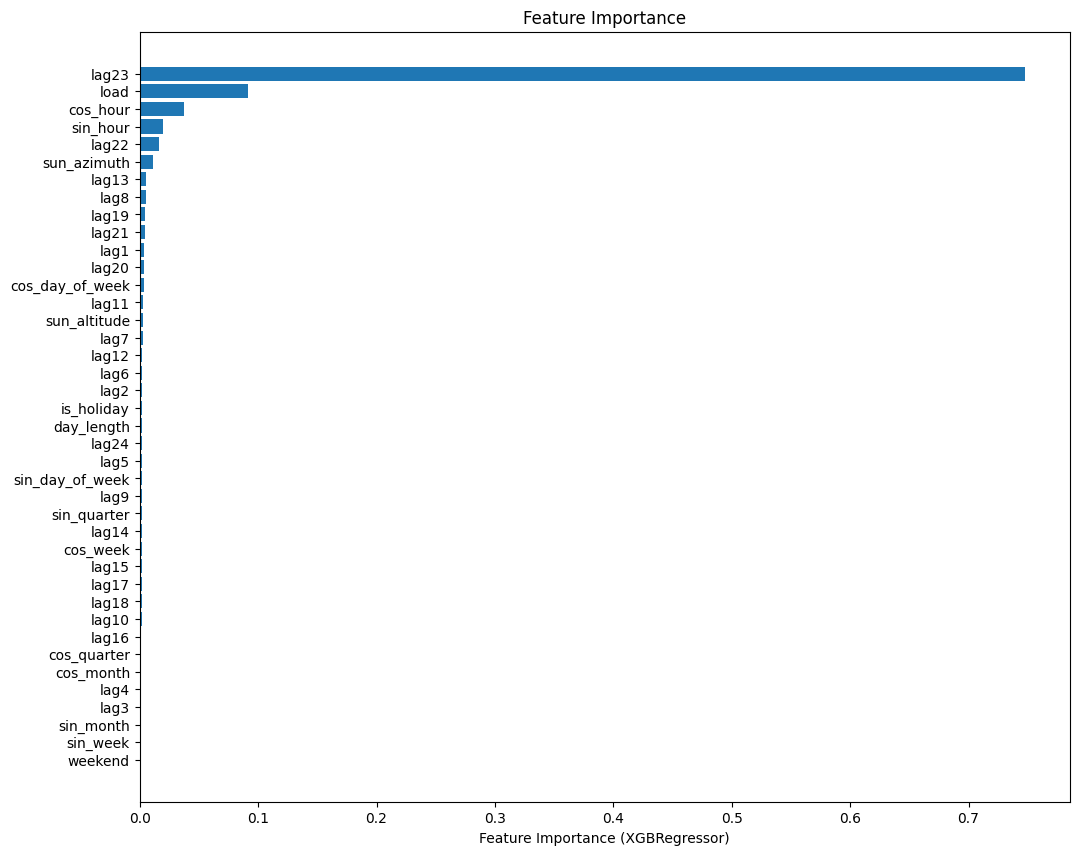

In [88]:
sorted_idx = xgb_reg.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(12,10))
plt.title('Feature Importance')
plt.barh(X.columns.values[sorted_idx], xgb_reg.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance (XGBRegressor)")
plt.show()

## Permutation Importance 
*The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled*

In [89]:
perm_importance = permutation_importance(xgb_reg, X_test_scl, y_test_scl)

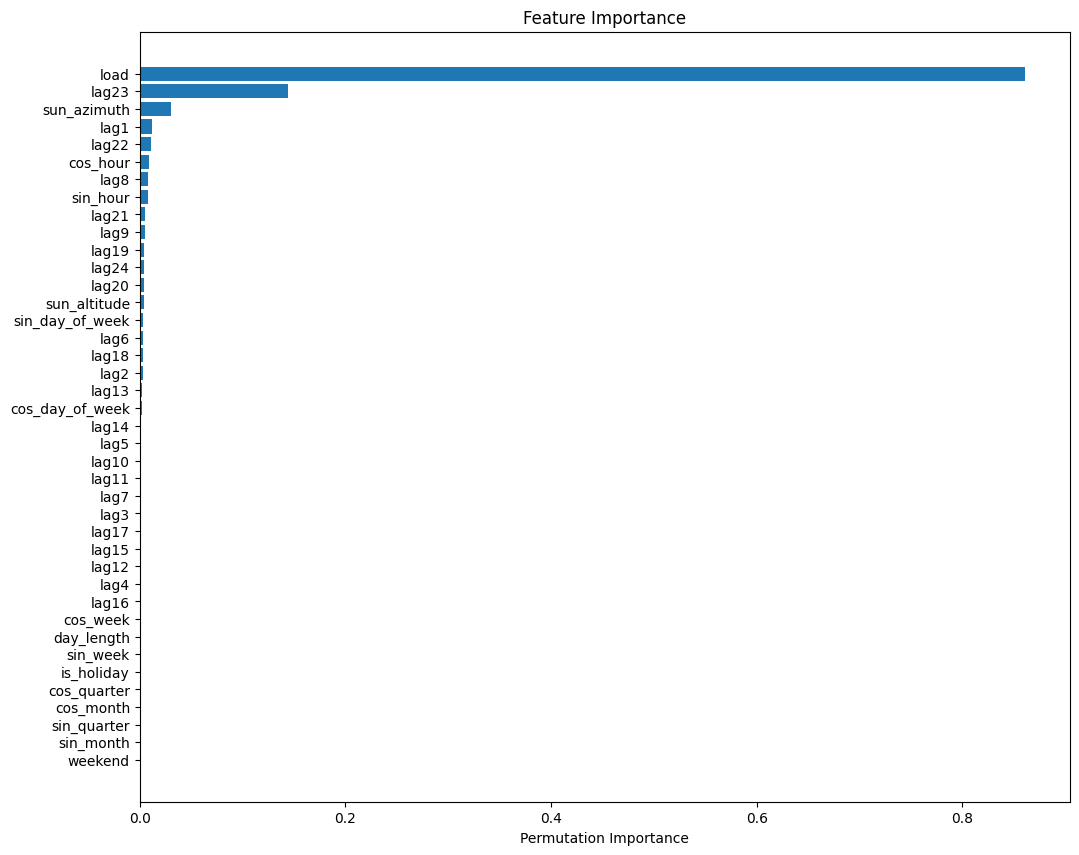

In [90]:
sorted_idx = perm_importance.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12,10))
plt.title('Feature Importance')
plt.barh(X.columns.values[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

## Feature Importance and Explanation using Shapley (SHAP) Values
A larger SHAP value means a positive impact on the prediction (i.e. higher values). Negative SHAP values means negative impact leading to lower values.

In [84]:
explainer = shap.TreeExplainer(xgb_reg, verbosity=0)
shap_values = explainer.shap_values(X_test_scl)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


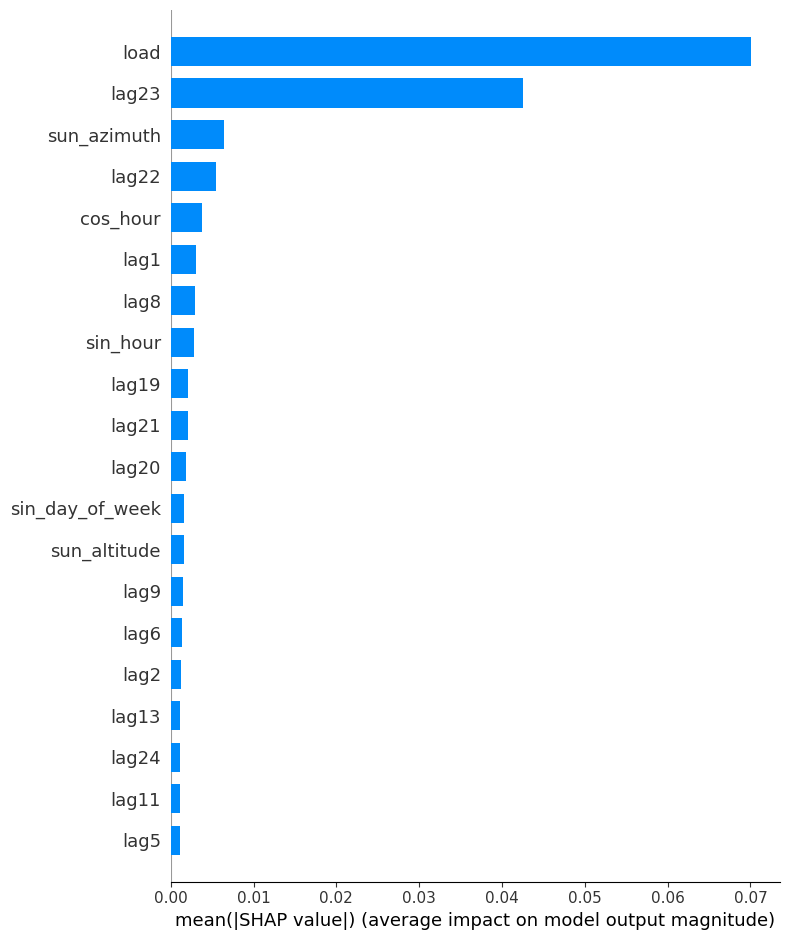

In [85]:
shap.summary_plot(shap_values, X_test_scl, plot_type="bar", feature_names=X.columns.values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


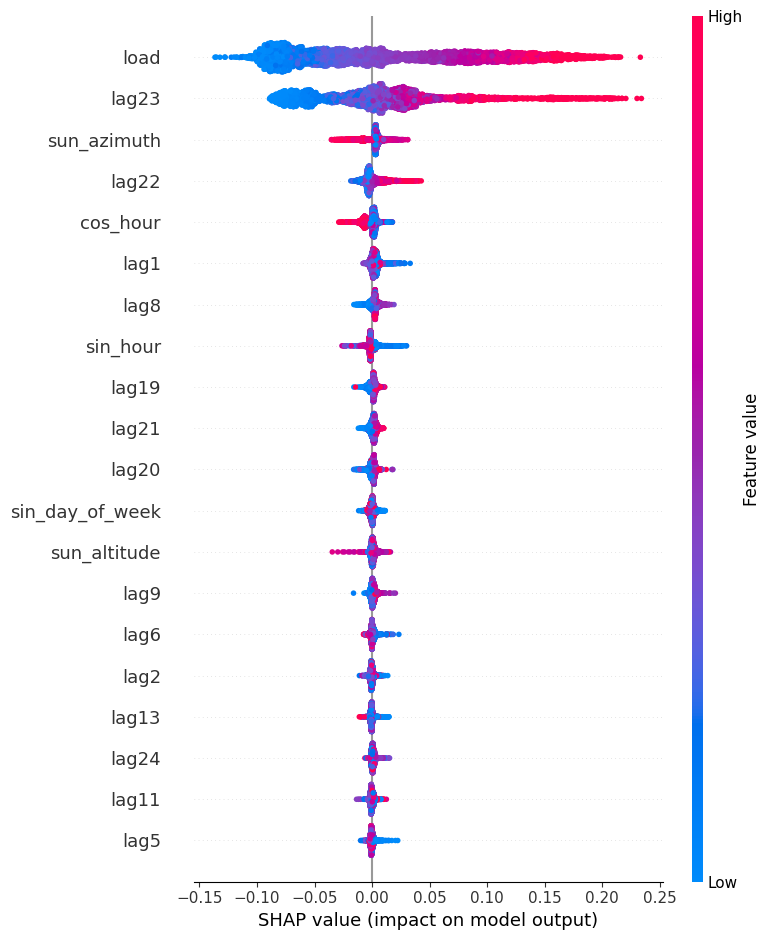

In [86]:
shap.summary_plot(shap_values, X_test_scl, feature_names=X.columns.values)

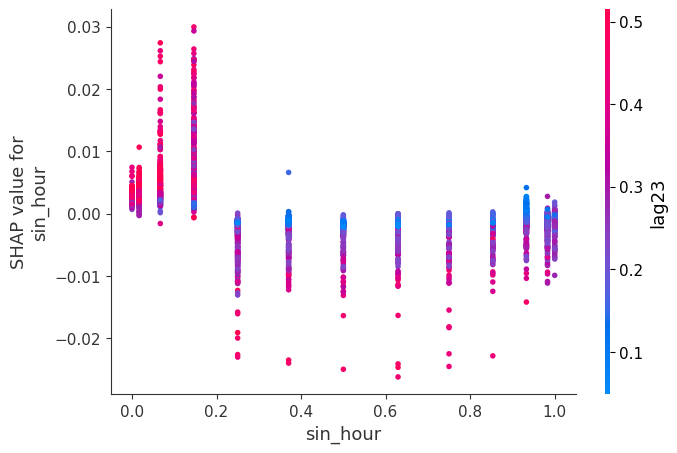

In [87]:
shap.dependence_plot("sin_hour", shap_values, X_test_scl, feature_names=X.columns.values)

# Finding Baseline Model Metrics
## XGBoost Regressor

In [42]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    objective='reg:squarederror',
    tree_method='hist'
)

train_model = MultiOutputRegressor(model).fit(X_train_scl, y_train_scl)

preds = train_model.predict(X_test_scl)

NameError: name 'X_train_scl' is not defined

In [92]:
df_results = format_predictions(preds, y_test_scl, X_test, y_scaler)

In [93]:
xgb_metrics = calculate_metrics(df_results)

Mean Absolute Error:       4.5083186982432775
Root Mean Squared Error:   6.091003418643591
R^2 Score:                 0.961895549794082
Mean Absolute % Error:     5.093995187348059


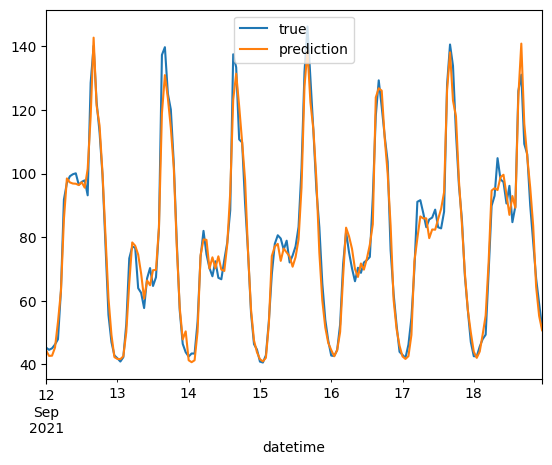

In [94]:
df_results[:168].plot()
plt.show()

In [96]:
final_features = features[['load', 'sin_hour', 'cos_hour', 'lag22', 'lag23', 'sun_azimuth']]
final_features.head()

,load,sin_hour,cos_hour,lag22,lag23,sun_azimuth
datetime,,,,,,
2019-01-02 00:00:00,61.68,0.000000,1.000000,84.52,92.44,-2.886768
2019-01-02 01:00:00,54.35,0.258819,0.965926,75.36,84.52,-2.480900
2019-01-02 02:00:00,51.65,0.500000,0.866025,63.64,75.36,-2.145621
2019-01-02 03:00:00,49.20,0.707107,0.707107,56.20,63.64,-1.871050
2019-01-02 04:00:00,50.60,0.866025,0.500000,57.83,56.20,-1.636126


In [97]:
final_features.to_csv('../data/final_data.csv', index='datetime')

# Feature Selection
Based on the above analysis of feature importances, we can continue with:
- Hour
- Week
- Day of Week
- Is Holiday

#### Add Lags


In [52]:
features = generate_lags(features, 24, 'load')
features.head()

,load,is_holiday,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,sin_week,cos_week,sin_month,cos_month,...,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-02 00:00:00,61.68,0,0.000000,1.000000,0.974928,-0.222521,0.0,1.0,0.0,1.0,...,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52,92.44,112.01
2019-01-02 01:00:00,54.35,0,0.258819,0.965926,0.974928,-0.222521,0.0,1.0,0.0,1.0,...,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52,92.44
2019-01-02 02:00:00,51.65,0,0.500000,0.866025,0.974928,-0.222521,0.0,1.0,0.0,1.0,...,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52
2019-01-02 03:00:00,49.20,0,0.707107,0.707107,0.974928,-0.222521,0.0,1.0,0.0,1.0,...,127.97,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36
2019-01-02 04:00:00,50.60,0,0.866025,0.500000,0.974928,-0.222521,0.0,1.0,0.0,1.0,...,122.67,127.97,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64


In [39]:
#X = features.drop(['load', 'weekend', 'cos_quarter', 'sin_quarter', 'sin_month',
#                   'cos_month', 'sun_altitude', 'day_length', 'sun_azimuth'], axis=1)

X = features[['sin_hour', 'cos_hour', 'lag1', 'lag24']]
y = features[['load']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling due to larger values affecting the decision tree
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scl = x_scaler.fit_transform(X_train)
X_test_scl = x_scaler.transform(X_test)
y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [40]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    objective='reg:squarederror',
    tree_method='hist'
)

train_model = MultiOutputRegressor(model).fit(X_train_scl, y_train_scl)

preds = train_model.predict(X_test_scl)

In [41]:
df_results = format_preds(preds, y_test_scl, X_test, y_scaler)
xgb_metrics = calc_metrics(df_results)

Mean Absolute Error:       7.156007546808968
Root Mean Squared Error:   10.085408392399243
R^2 Score:                 0.8954686048867663
Mean Absolute % Error:     8.280314041668738


In [42]:
X.head()

,is_holiday,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,sin_week,cos_week
datetime,,,,,,,
2019-01-01 00:00:00,1,0.000000,1.000000,0.781831,0.62349,0.0,1.0
2019-01-01 01:00:00,1,0.258819,0.965926,0.781831,0.62349,0.0,1.0
2019-01-01 02:00:00,1,0.500000,0.866025,0.781831,0.62349,0.0,1.0
2019-01-01 03:00:00,1,0.707107,0.707107,0.781831,0.62349,0.0,1.0
2019-01-01 04:00:00,1,0.866025,0.500000,0.781831,0.62349,0.0,1.0


In [51]:
features.to_csv('../data/final_data.csv', index='datetime')

# Feature Selection Technique - Forward / Backward Selection
The following two parts are optional, as we have analysed the features thoroughly already. It is just another way to do it.
## Forward

In [43]:
from sklearn.feature_selection import SequentialFeatureSelector

forward_sfs = SequentialFeatureSelector(xgb_reg, direction='forward', n_features_to_select='auto')
forward_sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=XGBRegressor(base_score=0.5,
                                                 booster='gbtree',
                                                 callbacks=None,
                                                 colsample_bylevel=1,
                                                 colsample_bynode=1,
                                                 colsample_bytree=1,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=0,
                                                 gpu_id=-1,
                                                 grow_policy='depthwise',
                                                 importance_type='gain',
                                                 interaction_constraints='',
                                                 kwargs={'colsamp...
                                                         'eval_metric': 'rmse',
                                                         'max_depth': 10,
                                                         'objective': 'reg:squarederror',
                                                         'subsample': 1.0},
                                                 learning_rate=0.300000012,
                                                 max_bin=256,
                                                 max_cat_threshold=64,
                                                 max_cat_to_onehot=4,
                                                 max_delta_step=0, max_depth=10,
                                                 max_leaves=0,
                                                 min_child_weight=1,
                                                 missing=nan,
                                                 monotone_constraints='()',
                                                 n_estimators=100, n_jobs=0,
                                                 num_parallel_tree=1,
                                                 predictor='auto', ...),
                          n_features_to_select='auto')

In [44]:
# Bool Index for which features to use
forward_sfs.get_support()

array([False,  True,  True, False, False, False,  True])

In [45]:
X_train_sel = forward_sfs.transform(X_train)
X_test_sel = forward_sfs.transform(X_test)

X_train_scl = x_scaler.fit_transform(X_train_sel)
X_test_scl = x_scaler.transform(X_test_sel)
y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [66]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    objective='reg:squarederror',
    tree_method='hist'
)

train_model = MultiOutputRegressor(model).fit(X_train_scl, y_train_scl)

preds = train_model.predict(X_test_scl)

df_results = format_preds(preds, y_test_scl, X_test, y_scaler)
xgb_metrics = calc_metrics(df_results)

Mean Absolute Error:       9.01311099382579
Root Mean Squared Error:   11.783278804615463
R^2 Score:                 0.8573104803065519
Mean Absolute % Error:     10.409945600786687


## Backward

In [46]:
backward_sfs = SequentialFeatureSelector(xgb_reg, direction='backward', n_features_to_select='auto')
backward_sfs.fit(X_train, y_train)
backward_sfs.get_support()

array([False,  True,  True,  True, False, False,  True])

In [47]:
X_train_sel = forward_sfs.transform(X_train)
X_test_sel = forward_sfs.transform(X_test)

X_train_scl = x_scaler.fit_transform(X_train_sel)
X_test_scl = x_scaler.transform(X_test_sel)
y_train_scl = y_scaler.fit_transform(y_train)
y_test_scl = y_scaler.transform(y_test)

In [48]:
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    objective='reg:squarederror',
    tree_method='hist'
)

train_model = MultiOutputRegressor(model).fit(X_train_scl, y_train_scl)

preds = train_model.predict(X_test_scl)

df_results = format_preds(preds, y_test_scl, X_test, y_scaler)
xgb_metrics = calc_metrics(df_results)

Mean Absolute Error:       9.01311099382579
Root Mean Squared Error:   11.783278804615463
R^2 Score:                 0.8573104803065519
Mean Absolute % Error:     10.409945600786687


# Feature importance using Ridge Regression Coefficients

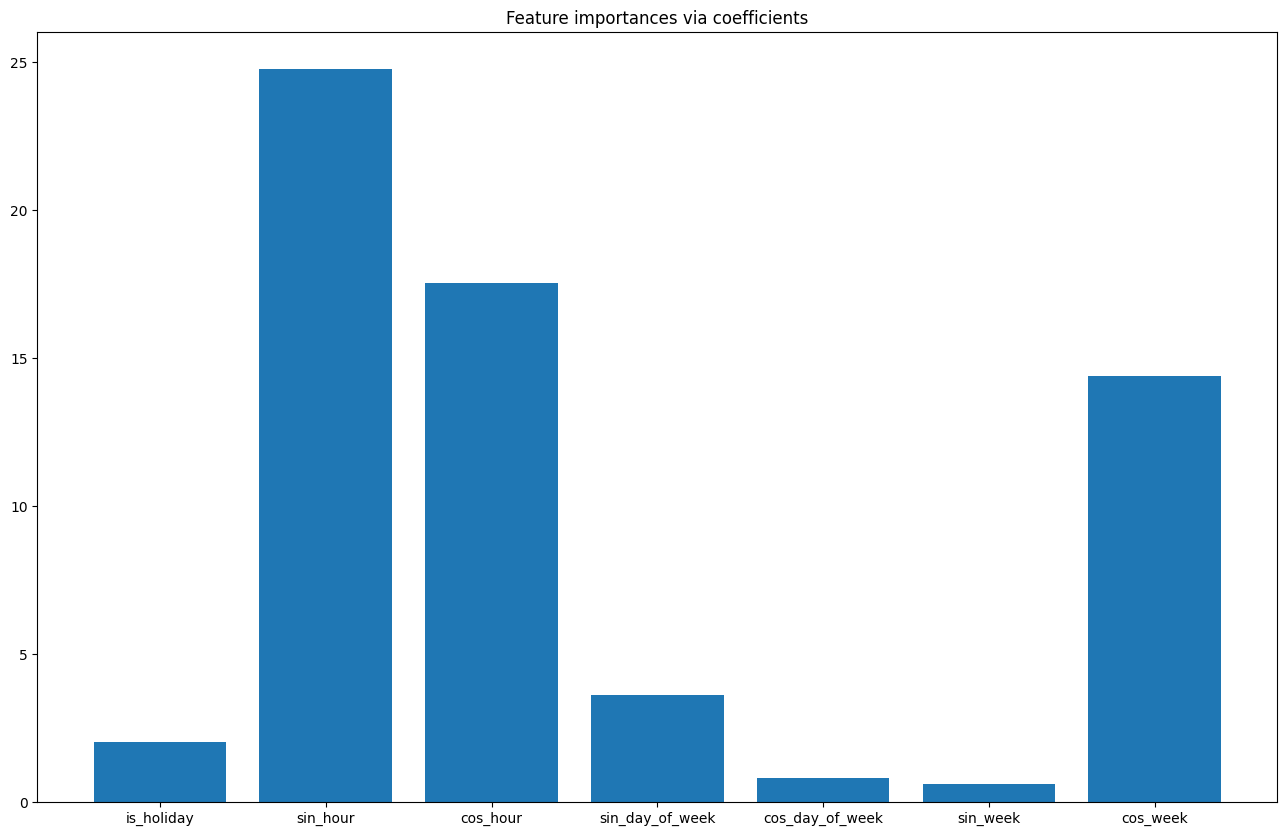

In [105]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
feature_names = np.array(X.columns.values)
plt.figure(figsize=(16,10))
plt.bar(height=importance.flatten(), x=feature_names)
plt.title("Feature importances via coefficients (Cross Validated Ridge Regression)")
plt.show()